In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [11]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.PGAN_model.PGAN import PGAN

import torch
import pytorch_lightning as pl
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

In [12]:
# # hyperparameters
# z_dim = 100
latent_dim = 100
batch_size = 32
depths = [256, 256, 128, 64, 32, 16]
num_epochs = 60
num_epochs_per_resolution = int(num_epochs / len(depths))
learning_rate = 0.001
# beta1 = 0.5

# base_directory = "../data/raw/nsynth-train/audio"
base_directory = "../data/raw/Bass"

dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/graph_model')

In [6]:
dataiter = iter(dataloader)
spectrograms = next(dataiter)
spectrograms.shape

torch.Size([32, 1, 256, 160])

In [7]:
Music_PGAN = PGAN(depths=depths)

In [8]:
writer.add_graph(Music_PGAN, spectrograms)
writer.close()

TypeError: 'bool' object is not iterable

In [6]:
Music_PGAN.train(dataloader=dataloader, num_epochs_per_resolution=num_epochs_per_resolution, fade_in_percentage=0.5)

Resolution 0 - Epoch 1/10 - D Loss: 0.37525513768196106 - G Loss: 0.6832995414733887
Resolution 0 - Epoch 2/10 - D Loss: 0.27904367446899414 - G Loss: 0.3712693750858307
Resolution 0 - Epoch 3/10 - D Loss: 0.14096218347549438 - G Loss: 0.8422595262527466
Resolution 0 - Epoch 4/10 - D Loss: 0.25800657272338867 - G Loss: 0.5519708395004272
Resolution 0 - Epoch 5/10 - D Loss: 0.19610074162483215 - G Loss: 0.7159310579299927
Resolution 0 - Epoch 6/10 - D Loss: 1.5485787391662598 - G Loss: 1.3946207761764526
Resolution 0 - Epoch 7/10 - D Loss: 0.28698569536209106 - G Loss: 0.506611168384552
Resolution 0 - Epoch 8/10 - D Loss: 0.3950696885585785 - G Loss: 0.51609206199646
Resolution 0 - Epoch 9/10 - D Loss: 0.2728966474533081 - G Loss: 0.4449431300163269
Resolution 0 - Epoch 10/10 - D Loss: 0.41211825609207153 - G Loss: 0.4497823119163513
Resolution 1 - Epoch 1/10 - D Loss: 0.19308434426784515 - G Loss: 0.6831037402153015
Resolution 1 - Epoch 2/10 - D Loss: 0.0753965824842453 - G Loss: 0.728

In [7]:
Music_PGAN.writer.close()

In [67]:
Music_PGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
        (3): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
        (3): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(

In [68]:
z = torch.randn(1, Music_PGAN.latent_dim).to(Music_PGAN.device)
generated_spectrogram = Music_PGAN.generator(z)

In [69]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
spectrogram = spectrogram.squeeze()

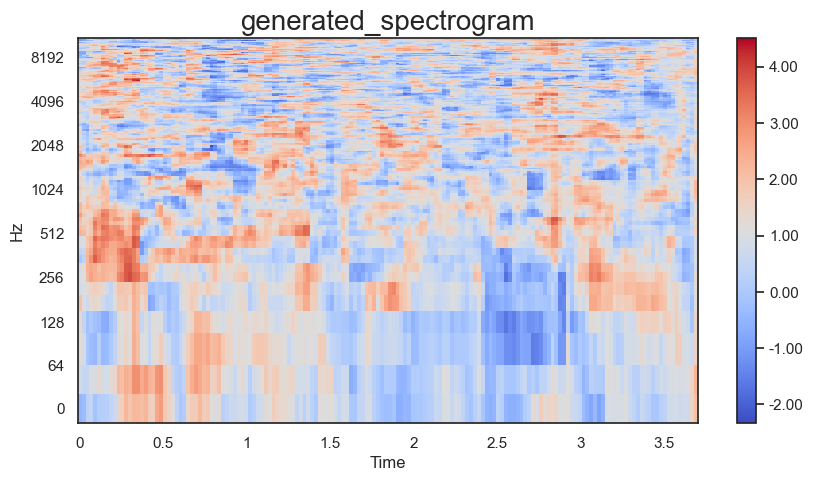

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
plt.title('generated_spectrogram', fontsize=20)
plt.colorbar(img, format='%0.2f')

plt.show()

In [52]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'PGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)